In [ ]:

from pyseter.sort import load_features
from pyseter.identify import predict_ids
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def where(list, value):
    try:
        return (list.index(value) + 1)
    except ValueError:
        return np.nan

# load in the feature vectors
data_dir = '/Users/PattonP/datasets/happywhale/'
feature_dir = data_dir + '/features'

reference_path = feature_dir + '/train_features.npy'
reference_files, reference_features = load_features(reference_path)

query_path = feature_dir + '/test_features.npy'
query_files, query_features = load_features(query_path)

# # get the ids for individuals in the reference set
# id_df = pd.read_csv(data_dir + '/train.csv')

In [ ]:
data_url = (
    'https://raw.githubusercontent.com/philpatton/pyseter/main/' 
    'data/happywhale-ids.csv'
)
id_df = pd.read_csv(data_url)

id_df = id_df.set_index('image')
id_df.head(5)

,species,individual_id
image,,
000110707af0ba.jpg,gray_whale,fbe2b15b5481
00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9
000562241d384d.jpg,humpback_whale,1a71fbb72250
0006287ec424cb.jpg,false_killer_whale,1424c7fec826
0007c33415ce37.jpg,false_killer_whale,60008f293a2b


In [ ]:
#| code-fold: true
# excel on mac corrupts the IDs (no need to do this on PC or linux)
id_df['individual_id'] = id_df['individual_id'].apply(
    lambda x: str(int(float(x))) if 'E+' in str(x) else x
)

In [65]:
from pyseter.identify import find_neighbors, insert_new_id, pool_predictions
import numpy as np

# this is the true id of every id in the reference dataset
ids = id_df.loc[reference_files, 'individual_id'].to_numpy()

# takes about 19 seconds
distance_matrix, index_matrix = find_neighbors(reference_features, query_features)

# get the corresponding labels for each reference image
predicted_ids = ids[index_matrix]

# insert the prediction "new_individual" at the threshold
distances, ids = insert_new_id(distance_matrix, predicted_ids, threshold=0.5)

# remove redundant predictions and take the minimum distance 
pooled_distances, pooled_ids = pool_predictions(ids, distances)

In [105]:
records = []
for i, image in enumerate(query_files):

    # where is the true id in the list of predicted IDs?
    true_id = id_df.loc[image]['individual_id']
    rank = where(pooled_ids[i].tolist(), true_id)

    # these will become the rows in our dataframe
    records.append({'image': image, 'rank': rank})

df = pd.DataFrame.from_records(records).set_index('image').join(id_df)
df.head()

,rank,species,individual_id
image,,,
a704da09e32dc3.jpg,5.0,frasiers_dolphin,43dad7ffa3c7
de1569496d42f4.jpg,1.0,pilot_whale,ed237f7c2165
4ab51dd663dd29.jpg,1.0,beluga,b9b24be2d5ae
da27c3f9f96504.jpg,1.0,bottlenose_dolpin,c02b7ad6faa0
0df089463bfd6b.jpg,3.0,dusky_dolphin,new_individual


In [106]:
df_list = []

# how many of the proposed ids did you check?
for a in range(1, 26):

    # was the true id further down the list?
    # i.e., had you kept looking would you have found it?
    missed_match = df['rank'] > a

    # is this individual in the reference set? we're assuming no false positives
    not_new = df['individual_id'] != 'new_individual'

    # if both are true, then you committed a false negative error
    df['error'] = missed_match & not_new

    fn_df = df.groupby('species')['error'].mean().rename('fn_rate').reset_index()
    fn_df['a'] = a
    
    df_list.append(fn_df)

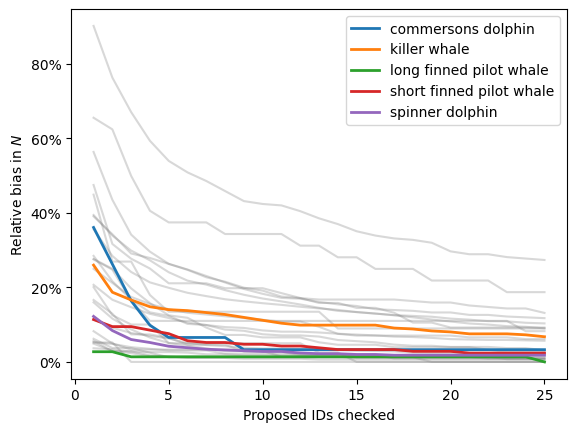

In [136]:
fn_df = pd.concat(df_list)
fn_df['rbias'] = fn_df['fn_rate'] * 2.56
fn_df = fn_df.loc[fn_df['species'] != 'frasiers_dolphin'].reset_index()

specials = fn_df.sample(5, random_state=10).species.unique()
special_df = fn_df.loc[fn_df.species.isin(specials)]
nonspecial_df = fn_df.loc[~fn_df.species.isin(specials)]

fig, ax = plt.subplots()

for name, df in nonspecial_df.groupby('species'):
    ax.plot(df.a, df.rbias, alpha=0.3, c='tab:grey', zorder=-2)

for name, df in special_df.groupby('species'):
    ax.plot(df.a, df.rbias, label=name.replace('_', ' '), linewidth=2)

import matplotlib.ticker as mtick
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))

ax.set_ylabel(r'Relative bias in $N$')
ax.set_xlabel(r'Proposed IDs checked')
ax.legend()